# Exploring car prices and transmissions

This notebook walks through a small data analysis project on used cars. I start with simple linear regression to understand how individual features relate to price, then move on to multivariate linear regression and finally logistic regression to predict whether a car has automatic or manual transmission.


## Simple univariate regression helper

Before working with the real car data, I use a small helper class, `SimpleLinearRegression`, that implements the closed‑form solution for univariate linear regression.

The aim is to fit a line of the form

\[
y = \beta_0 + \beta_1 x
\]

to a single feature. The `fit` method computes the slope and intercept using the usual least‑squares formulas and stores them in attributes that follow the scikit‑learn convention:

- `coef_`: a one‑element array containing the slope.
- `intercept_`: a plain floating‑point number with the intercept.

The corresponding `predict` method then takes an \(n \times 1\) array of inputs and returns the model predictions using those fitted parameters.

This small class mirrors what scikit‑learn does internally, but staying in the simple one‑dimensional case makes it easy to reason about and to inspect the parameters.


In [ ]:
import numpy as np

class SimpleLinearRegression:
    """
    Uses closed-form formulae to implement the simple linear regression using least squares.
    """

    def fit(self,X,y):
        """
        Fits the model on the observations (X,y) using least squares.

        Parameters:
        - X : n*1 array of univariate observations (independent variable)
        - y : n array of univariate observations (dependent variable)

        Return value:
        - Returns self
        """
        assert isinstance(X,np.ndarray) and isinstance(y,np.ndarray)        
        assert X.ndim == 2 and y.ndim == 1
        assert X.shape[0] == y.shape[0] and X.shape[1] == 1

        # using the least squares formula to find beta
        # we want y = kx + m
        one_dim_x = X[:,0]
        x_m = np.mean(one_dim_x)
        y_m = np.mean(y)
        # now we find the sums that go in the division
        x_tot = (one_dim_x - x_m)
        y_tot = (y- y_m)

        beta = np.sum(x_tot*y_tot) / np.sum(x_tot*x_tot)

        # to arr
        self.coef_ = np.array([beta])

        self.intercept_ = y_m - self.coef_[0] *x_m
        
        return self
        

    def predict(self,X):
        """
        Returns model predictions y = a+b*x for all observations given as input.

        Parameters:
        - X : n*1 array of univariate observations

        Return value:
        - An array of length n of predictions
        """
        assert isinstance(X,np.ndarray)
        assert X.ndim == 2 and X.shape[1] == 1

        # return y= kx+m
        one_dim_x = X[:,0]
        return self.intercept_ + self.coef_[0] * one_dim_x


## Loading and cleaning the car dataset

Next I load the raw Blocket car data into a dataframe called `df_raw` and take a quick look at the columns to understand what each variable represents:

- price is given in SEK,
- mileage is given in Scandinavian miles (*mil*),
- horsepowers refers to the power of the engine,
- *Car type* describes the body/chassis style,
- engine size is given in cubic centimetres (cc),
- registration date is the first registration date in traffic, when available.

Some rows in the file are clearly incomplete or suspicious (for example, missing prices or mileage, or obviously wrong values). In the following cell I remove those problematic observations while keeping all information that is needed later, in particular the target variables for the models.

The cleaned version of the data is stored as `df`, and that is what the rest of the notebook works with.


In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split

# 'Price', 'Location', 'Fuel', 'Transmission', 'Mileage', 'Model year',
#        'Car type', 'Drivetrain', 'Color', 'Horsepowers', 'Engine size',
#        'Manufacturer', 'Model', 'Registration date'


df_raw = pd.read_csv('blocket_cars.csv')

def dat(df_raw):
    
    for col in df_raw.columns:
        if col == 'Price':
            df_raw[col] = df_raw[col].apply(lambda x: None if x < 10000 else (None if x >3_000_000 else x))
        elif col == 'Mileage':
            df_raw[col] = df_raw[col].apply(lambda x: None if x == 0 else (None if x > 50_000 else x))
        elif col == 'Horsepowers':
            df_raw[col] = df_raw[col].apply(lambda x: None if x > 1_000 else x)
        else:
            pass
        df_raw = df_raw.dropna(subset=['Price']).reset_index(drop=True)
        df_raw = df_raw.dropna(subset=['Mileage']).reset_index(drop=True)
        df_raw = df_raw.dropna(subset=['Transmission']).reset_index(drop=True)
        df_raw = df_raw.dropna(subset=['Horsepowers']).reset_index(drop=True)
    df_new =  df_raw
    return df_new
df = dat(df_raw)

df_train, df_test = train_test_split(df, test_size=0.25, random_state=10)

## Correlations between numerical features and price

With a cleaned dataset in place, I now look at how strongly each numerical feature is linearly related to the car price. In the next cell I compute the Pearson correlation matrix over the numerical columns and then identify which feature has the strongest (absolute) correlation with price.

I keep the name of that feature in `most_correlated_feature` and the corresponding correlation coefficient in `most_correlated_feature_corr`. This will later guide the choice of feature for the first simple regression model.


In [ ]:

import pandas as pd
import numpy as np

numerical_features = df_train.select_dtypes(include=["number"])
corr_m = numerical_features.corr(method = 'pearson')['Price']
corr_m_no_price = corr_m.drop('Price')
most_correlated_feature_corr = corr_m_no_price.abs().max()
most_correlated_feature = corr_m_no_price.idxmax()


## A first simple price model

Using the most strongly correlated feature from above, I fit a simple univariate linear regression model to predict car prices.

The code trains the model on the training split and then evaluates how well this one‑dimensional relationship captures the variation in price. To quantify the performance I compute:

- \(R^2\) on the training data,
- root‑mean‑square error (RMS),
- mean absolute error (MAE),
- mean absolute percentage error (MAPE).

These metrics are stored in variables such as `r2`, `rms`, `mae`, and `mape` so that they can be compared with later models.


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

# testing data
X_train = df_train[[most_correlated_feature]].values
y_train = df_train["Price"].values
# trainig data
X_test = df_test[[most_correlated_feature]].values
y_test = df_test["Price"].values


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


beta = np.sum(X_train_scaled.flatten() * (y_train - np.mean(y_train))) / np.sum(X_train_scaled.flatten() ** 2)
alpha = np.mean(y_train)  

# our predictions y = kx+m
y_train_pred = beta * X_train_scaled.flatten() + alpha
y_test_pred = beta * X_test_scaled.flatten() + alpha

# manual computation
SS_res = np.sum((y_train - y_train_pred) ** 2)
SS_tot = np.sum((y_train - np.mean(y_train)) ** 2)
r2 = 1 - (SS_res / SS_tot)


rms = np.sqrt(mean_squared_error(y_test, y_test_pred)) 
mae = mean_absolute_error(y_test, y_test_pred)
mape = mean_absolute_percentage_error(y_test, y_test_pred)

'\nprint(f"Beta {beta}")\nprint(f"Alpha {alpha}")\nprint(f"r2 Manual Training Calculation {r2_manual}")\nprint(f"r2 using function from Sklearn {r2}")\nprint(f"RMS  {rms}")\nprint(f"MAE {mae}")\nprint(f"MAPE  {mape}")'

## Visualising the simple regression fit

To get an intuitive feel for this first model, the next cell creates a scatter plot of the test data (feature vs. price) and overlays the fitted regression line.

The plotting code returns the Matplotlib axes object in a variable called `ax`, and labels the axes and title so it is clear what relationship is being visualised.


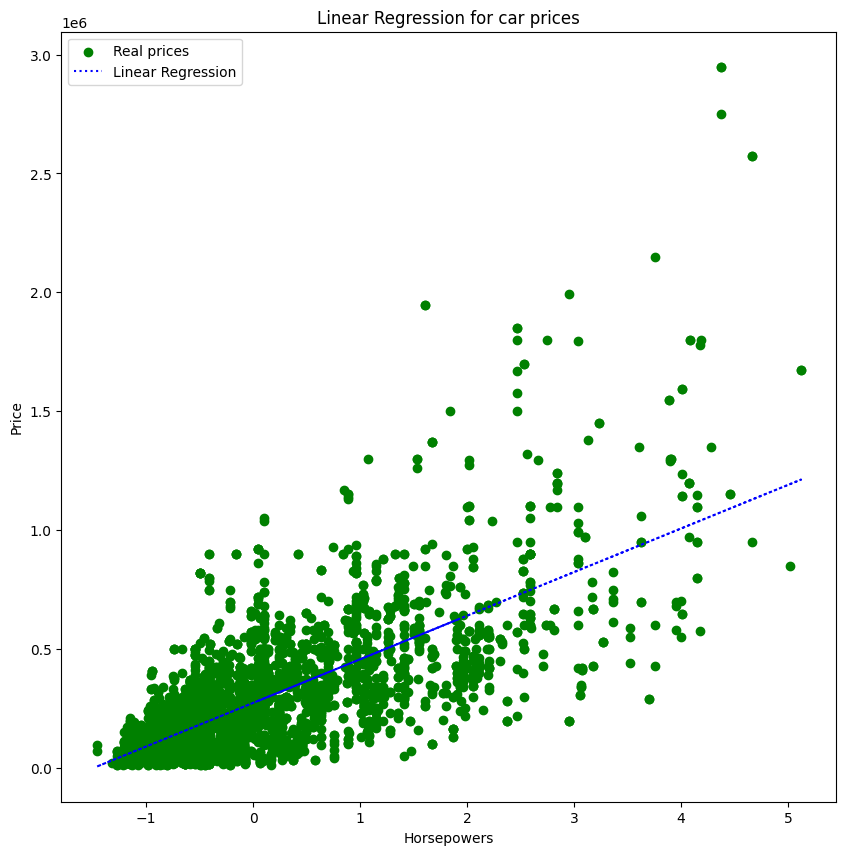

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(X_test_scaled, y_test, color='green', label='Real prices')
ax.plot(X_test_scaled, y_test_pred, color='blue', linestyle='dotted', label='Linear Regression')


ax.set_xlabel(most_correlated_feature)
ax.set_ylabel("Price")
ax.set_title("Linear Regression for car prices")
ax.legend()

plt.show()



## Focusing on a more homogeneous subset

The overall dataset spans many brands and model years, so the price dynamics can vary a lot across the full range. To make the model more meaningful, the following step restricts attention to a more homogeneous subset of the data (for example a particular manufacturer and/or more recent model years).

On this restricted dataset:

- I recompute the correlations to find the single numerical feature that is now most strongly related to price, storing its name in `most_correlated_feature_top` and the correlation value in `most_correlated_feature_top_corr`.
- I then fit another simple univariate linear regression model using this feature only on the subset, and evaluate it using \(R^2\), RMS, MAE, and MAPE on the corresponding training and test splits.

The resulting error measures are recorded as `rms_top`, `mae_top`, and `mape_top` so they can be compared with the previous, more global model.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Most common manufacturer
top_manufacturer = df["Manufacturer"].mode()[0]
df_train_top = df_train[(df_train["Manufacturer"] == top_manufacturer) & (df_train["Model year"] >= 2010)]
df_test_top = df_test[(df_test["Manufacturer"] == top_manufacturer) & (df_test["Model year"] >= 2010)]

# only numerical columns
numeric_cols = df_train_top.select_dtypes(include=[np.number])

correlation_matrix_top = numeric_cols.corr()
most_correlated_feature_top = correlation_matrix_top["Price"].drop("Price").idxmax()
# correlation value
most_correlated_feature_top_corr = correlation_matrix_top["Price"][most_correlated_feature_top] 


X_train_top = df_train_top[[most_correlated_feature_top]].values
y_train_top = df_train_top["Price"].values
X_test_top = df_test_top[[most_correlated_feature_top]].values
y_test_top = df_test_top["Price"].values

mean_model_year = df_train_top["Model year"].mean()
std_model_year = df_train_top["Model year"].std()

# scale 'Model year' values
X_train_scaled_top = (X_train_top - mean_model_year) / std_model_year
X_test_scaled_top = (X_test_top - mean_model_year) / std_model_year

# Calculate beta (slope) and alpha (intercept) using the formulas from earlier question
beta_top = np.sum(X_train_scaled_top.flatten() * (y_train_top - np.mean(y_train_top))) / np.sum(X_train_scaled_top.flatten() ** 2)
alpha_top = np.mean(y_train_top)

y_train_pred_top = beta_top * X_train_scaled_top.flatten() + alpha_top
y_test_pred_top = beta_top * X_test_scaled_top.flatten() + alpha_top


SS_res_top = np.sum((y_train_top - y_train_pred_top) ** 2)
SS_tot_top = np.sum((y_train_top - np.mean(y_train_top)) ** 2)

r2_top = 1 - (SS_res_top / SS_tot_top)
rms_top = np.sqrt(mean_squared_error(y_test_top, y_test_pred_top))
mae_top = mean_absolute_error(y_test_top, y_test_pred_top)
mape_top = mean_absolute_percentage_error(y_test_top, y_test_pred_top)


'print(f"Top Manufacturer {top_manufacturer}")\nprint(f"Most Correlated Feature {most_correlated_feature_top}")\nprint(f"Correlation {most_correlated_feature_top_corr}")\nprint(f"r2 {r2_top}")\nprint(f"RMS {rms_top}")\nprint(f"MAE {mae_top}")\nprint(f"MAPE {mape_top}")'

## Plotting the subset model

Just like in the earlier visualisation, the next cell plots the test data for the restricted subset together with the fitted regression line (in the plotting code this is drawn as a dotted line) and stores the axes object in `ax`.

The figure is given descriptive axis labels and a title so the behaviour of prices within this subset is easy to interpret visually.


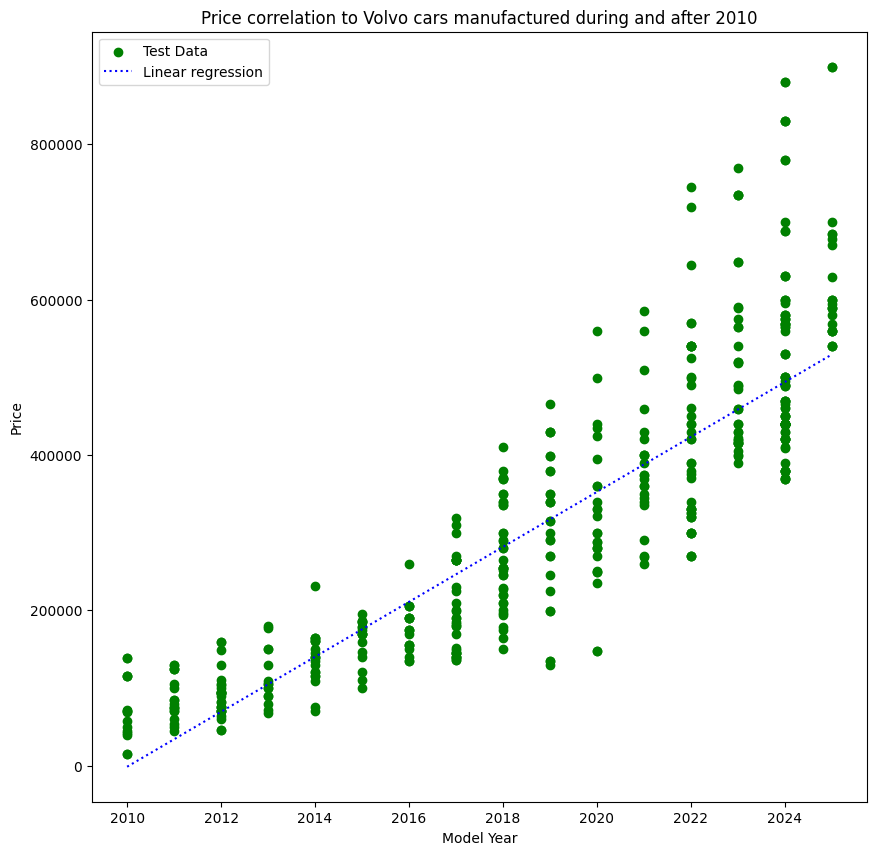

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(df_test_top["Model year"].values, df_test_top["Price"].values, color="green", label="Test Data")

# Create a range of model years for plotting the fitted line
model_year_range = np.linspace(df_test_top["Model year"].min(), df_test_top["Model year"].max(), 100)

# scale the model_year_range 
scaled_model_year_range = (model_year_range - mean_model_year) / std_model_year

# Predict prices using the model equation (y = beta * X + alpha)
predicted_prices = beta_top * scaled_model_year_range + alpha_top

ax.plot(model_year_range, predicted_prices, color='blue', linestyle='dotted', label='Linear regression')

ax.set_xlabel("Model Year")
ax.set_ylabel("Price")
ax.set_title("Price correlation to Volvo cars manufactured during and after 2010")
ax.legend()
plt.show()


## Moving to a multivariate price model

Using only a single feature clearly leaves a lot of structure unexplained. The next step therefore builds a multivariate linear regression model that uses several of the available variables (for example mileage, engine power, age, etc.) simultaneously to predict price.

The code assembles a design matrix from the chosen features, fits a linear regression model, and then evaluates it on the test set. As before, I keep track of:

- \(R^2\),
- RMS,
- MAE,
- MAPE,

storing them as `r2_mv`, `rms_mv`, `mae_mv`, and `mape_mv`. With a reasonably chosen feature set the multivariate model should reach about \(R^2 > 0.8\) and a MAPE below 20%, which is a substantial improvement over the simple univariate baselines.


In [ ]:
#inspiration from https://www.geeksforgeeks.org/ml-normal-equation-in-linear-regression/

from sklearn.linear_model import LinearRegression

mv_features = ['Model year', 'Horsepowers', 'Mileage']


X_train_mv = df_train_top[mv_features].values
y_train_mv = df_train_top['Price'].values
X_test_mv = df_test_top[mv_features].values
y_test_mv = df_test_top['Price'].values

mean_mv = df_train_top[mv_features].mean().values
std_mv = df_train_top[mv_features].std().values
std_mv[std_mv == 0] = 1

X_train_scaled_mv = (X_train_mv - mean_mv) / std_mv
X_test_scaled_mv = (X_test_mv - mean_mv) / std_mv

X_train_intercept = np.column_stack((np.ones(X_train_scaled_mv.shape[0]), X_train_scaled_mv))
beta_mv = np.linalg.inv(X_train_intercept.T @ X_train_intercept) @ X_train_intercept.T @ y_train_mv


X_test_intercept = np.column_stack((np.ones(X_test_scaled_mv.shape[0]), X_test_scaled_mv))
y_train_pred_mv = X_train_intercept @ beta_mv
y_test_pred_mv = X_test_intercept @ beta_mv


SS_res_mv = np.sum((y_train_mv - y_train_pred_mv) ** 2)
SS_tot_mv = np.sum((y_train_mv - np.mean(y_train_mv)) ** 2)

r2_mv = 1 - (SS_res_mv / SS_tot_mv)
rms_mv = np.sqrt(mean_squared_error(y_test_mv, y_test_pred_mv))
mae_mv = mean_absolute_error(y_test_mv, y_test_pred_mv)
mape_mv = np.mean(np.abs((y_test_mv - y_test_pred_mv) / y_test_mv))



## Predicting transmission type with logistic regression

The last modelling step in the notebook switches from regression to classification. Here the goal is to predict whether a car has automatic or manual transmission based on a few key features such as price, engine power (horsepower), model year, and mileage.

In the next cell I:

- encode the textual transmission information into a binary target variable, with automatic as the positive class (1) and manual as the negative class (0),
- split the data into training and test sets,
- fit a logistic regression model on the training data,
- and evaluate it on the test set using accuracy, precision, recall, and F1‑score.

These four evaluation measures are stored in the variables `acc`, `prec`, `rec`, and `fscore`.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_train['Transmission_lab'] = df_train['Transmission'].apply(lambda x: 1 if x == 'Automatic' else 0)
df_test['Transmission_lab'] = df_test['Transmission'].apply(lambda x: 1 if x == 'Automatic' else 0)

features = ['Price', 'Horsepowers', 'Model year', 'Mileage']

x_train_label = df_train[features].values
y_train_label = df_train['Transmission_lab'].values

x_test_label = df_test[features].values
y_test_label = df_test['Transmission_lab'].values


X_train, X_test, y_train, y_test = train_test_split(x_train_label, y_train_label, test_size=0.25, random_state=15)


lor = LogisticRegression(random_state=15)

lor.fit(x_train_label, y_train_label)

y_pred_label = lor.predict(x_test_label)


acc = accuracy_score(y_test_label, y_pred_label)
prec = precision_score(y_test_label, y_pred_label)
rec = recall_score(y_test_label, y_pred_label)
fscore = f1_score(y_test_label, y_pred_label)
